# Random tropical cyclone tracks

Once we've generated genesis points for our TC, it is time to then generate the tracks from those genesis points. It's this component that results in the 

The track generation module in TCRM uses an autoregressive model to simulate the movement and intensification (or weakening) of TCs, combined with regression models for parameters such as the radius to maximum wind speed. 

The process works by randomly generating the required number of genesis points, then stepping forward in time for each point and updating the speed, bearing, intensity rate of change and radius to maximum winds based on either a lag-1 autoregressive model, or a statistical model that relates parameters. 



## Multiple tracks from one genesis point

First, let's generate a number of tracks from a single genesis point. This shows how each realisation of a TC is different, even if starting from a fixed location. We start by importing the required modules for track generation and enabling the interactive maps.

In [1]:
%matplotlib notebook

import io
import os
import sys
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as feature

from os.path import join as pjoin

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, interact_manual, fixed, FloatSlider, Dropdown
import ipywidgets as widgets

from IPython.display import Image, display

from DataProcess.CalcFrequency import CalcFrequency
from DataProcess.CalcTrackDomain import CalcTrackDomain

from TrackGenerator.TrackGenerator import SamplePressure, TrackGenerator, Simulation
from TrackGenerator import trackLandfall
import time

from Utilities.config import ConfigParser

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

Set up a configuration file to be read in. We need to make sure that some of the preceding components of the model system have been executed, since the track generation component relies on being able to access the processed files that contain the statistical information.

In [2]:
configstr = """
[DataProcess]
InputFile=C:/WorkSpace/data/TC/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=False

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':90.,'xMax':180.,'yMin':-30.0,'yMax':-5.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=5000
YearsPerSimulation=10
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = C:/WorkSpace/tcrm/input/landmask.nc
mslpfile = C:/WorkSpace/tcrm/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=C:/WorkSpace/data/TC/aus

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=C:/WorkSpace/data/TC/aus/log/aus.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r06.csv.gz
path = C:/WorkSpace/data/TC/
filename = Allstorms.ibtracs_wmo.v03r06.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = C:/WorkSpace/data/MSLP
filename = slp.day.ltm.nc"""

config = ConfigParser()
config.readfp(io.BytesIO(configstr))
gridLimit = config.geteval('Region', 'gridLimit')


Now we set up the `TrackGenerator` instance, which will do the simulations. Most of this boilerplate is within the TCRM code normally, so there's no need to go into detail as to what we're loading here. 

In [6]:
outputPath = config.get('Output', 'Path')
nSimulations = 1
maxTimeSteps = 360
dt = 1.

gridSpace = config.geteval('Region', 'GridSpace')
gridInc = config.geteval('Region', 'GridInc')
gridLimit = config.geteval('Region', 'gridLimit')
mslpFile = config.get('Input', 'MSLPFile')
processPath = pjoin(outputPath, 'process')

CalcF = CalcFrequency(configstr, gridLimit)
meanFreq = CalcF.calc()
yrsPerSim = 1

mslp = SamplePressure(mslpFile)
landfall = trackLandfall.LandfallDecay(configstr, dt)
tg = TrackGenerator(processPath, gridLimit, gridSpace, gridInc,
                        mslp, landfall, dt=dt,
                        maxTimeSteps=maxTimeSteps)
tg.loadInitialConditionDistributions()
tg.loadCellStatistics()

CRITICAL:root:CDF file C:/WorkSpace/data/TC/aus\process\all_cell_cdf_init_rmax does not exist!
CRITICAL:root:Run AllDistribution option in main to generate those files.


In this next section, we set up an interactive map, where clicking on it will trigger the generation of a track from the clicked location. 

The key line below is `tracks = tg.generateTracks(1, 1, initLon=ilon, initLat=ilat)`. This runs the track generation algorithm, using a fixed initial longitude and latitude (where you clicked on the map). 

To clear the map, just re-run the cell.

<IPython.core.display.Javascript object>


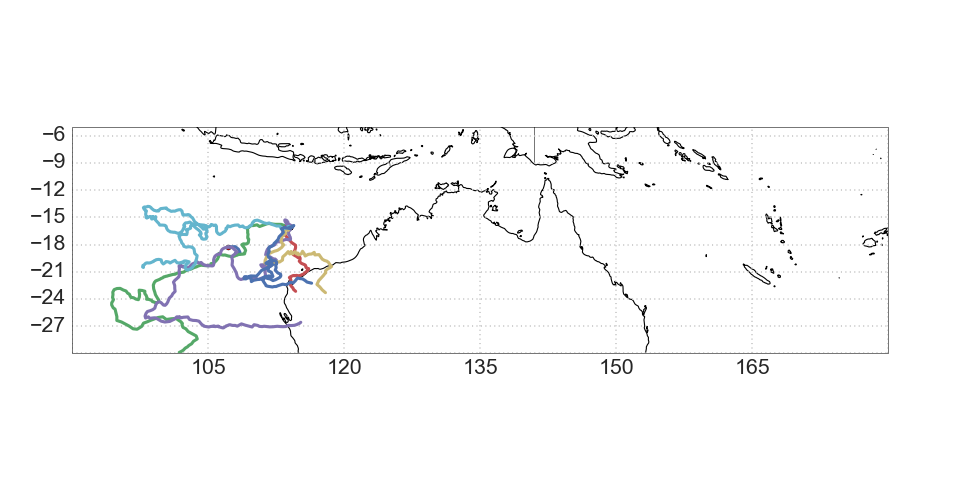

In [7]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(feature.BORDERS)
gl = ax.gridlines(linestyle=":", draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_xlim((gridLimit['xMin'], gridLimit['xMax']))
ax.set_ylim((gridLimit['yMin'], gridLimit['yMax']))

w = widgets.HTML()

def onclick(event):
    w.value = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(
              event.button, event.x, event.y, event.xdata, event.ydata)
    w.event = event
    plt.scatter(w.event.xdata, w.event.ydata, marker='o', facecolor='r')
    ilat, ilon = [w.event.ydata, w.event.xdata]
    tracks = tg.generateTracks(1, 1, initLon=ilon, initLat=ilat)
    plt.plot(tracks[0].Longitude, tracks[0].Latitude)
    
    print(w.event.xdata, w.event.ydata)
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)